In [18]:
import os
import sys
import pickle
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
from collections import Counter
import random
import pdb
random.seed(1028)

from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
project_path = '/scratch/yw3004/class/nlp/ds1011-nlp/hw2/'

## Data Preprocessing

### Save tokenized text data into lists of strings and labels

In [3]:
with open('snli_train.tsv') as f: 
    train_pairs = f.readlines()
with open('snli_val.tsv') as f: 
    val_pairs = f.readlines()

In [10]:
train_data = []
train_target = []
for line in train_pairs:
    seq1 = line.split('\t')[0].split()
    seq2 = line.split('\t')[1].split()
    label = line.split('\t')[2].split()
    
    train_data.append([seq1, seq2])
    if label == ['contradiction']:
        train_target.append(0)
    elif label == ['entailment']:
        train_target.append(1)
    elif label == ['neutral']:
        train_target.append(2)

train_data.pop(0)
train_target = np.array(train_target)

with open(os.path.join(project_path, 'train_data.pickle'), 'wb') as f:
        pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'train_target.pickle'), 'wb') as f:
        pickle.dump(train_target, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
val_data = []
val_target = []
for line in val_pairs:
    seq1 = line.split('\t')[0].split()
    seq2 = line.split('\t')[1].split()
    label = line.split('\t')[2].split()
    
    val_data.append([seq1, seq2])
    if label == ['contradiction']:
        val_target.append(0)
    elif label == ['entailment']:
        val_target.append(1)
    elif label == ['neutral']:
        val_target.append(2)

val_data.pop(0)
val_target = np.array(val_target)

with open(os.path.join(project_path, 'val_data.pickle'), 'wb') as f:
        pickle.dump(val_data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'val_target.pickle'), 'wb') as f:
        pickle.dump(val_target, f, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
train_data = pickle.load(open(os.path.join(project_path, 'train_data.pickle'), "rb"))
train_target = pickle.load(open(os.path.join(project_path, 'train_target.pickle'), "rb"))
val_data = pickle.load(open(os.path.join(project_path, 'val_data.pickle'), "rb"))
val_target = pickle.load(open(os.path.join(project_path, 'val_target.pickle'), "rb"))

## Load pre-trained word embeddings

In [33]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [34]:
data = load_vectors('wiki-news-300d-1M.vec')

In [35]:
pad_emb_idx = list(data.keys()).index('PAD')
pad_emb_idx

52948

In [36]:
unk_emb_idx = list(data.keys()).index('UNK')
unk_emb_idx

77808

In [37]:
with open('wiki-news-300d-1M.vec') as f: 
    embs = f.readlines()

In [38]:
embs.pop(0)

'999994 300\n'

In [39]:
max_vocab_size = 20000 #10000, #20000 #different vocab size
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

id2token = []
token2id = {}
weight = np.empty((max_vocab_size, 300))
for i in range(max_vocab_size):
    token = embs[i].split(' ')[0]
    vec = embs[i].split(' ')[1:]
    id2token.append(token)
    token2id[token] = i+2
    weight[i] = [float(el) for el in vec]
    
id2token = ['<pad>', '<unk>'] + id2token
token2id['<pad>'] = PAD_IDX 
token2id['<unk>'] = UNK_IDX
pad_vec = embs[pad_emb_idx].split(' ')[1:]
unk_vec = embs[unk_emb_idx].split(' ')[1:]
pad_weight = [float(el) for el in pad_vec]
unk_weight = [float(el) for el in unk_vec]

weight = np.vstack((unk_weight, weight))
weight = np.vstack((pad_weight, weight))

In [30]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for pair in tokens_data:
        indices_pair = []
        for tokens in pair:
            index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
            indices_pair.append(index_list)
        indices_data.append(indices_pair)
    return indices_data

train_data_indices = token2index_dataset(train_data)
val_data_indices = token2index_dataset(val_data)

In [12]:
with open(os.path.join(project_path, 'train_data_indices.pickle'), 'wb') as f:
    pickle.dump(train_data_indices, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'val_data_indices.pickle'), 'wb') as f:
    pickle.dump(val_data_indices, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'pre_train_emb.pickle'), 'wb') as f:
    pickle.dump(weight, f, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
train_data_indices = pickle.load(open(os.path.join(project_path, 'train_data_indices.pickle'), "rb"))
val_data_indices = pickle.load(open(os.path.join(project_path, 'val_data_indices.pickle'), "rb"))
weight = pickle.load(open(os.path.join(project_path, 'pre_train_emb.pickle'), "rb"))

In [5]:
weight = torch.from_numpy(weight)

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weight.to(device)

## Create Dataset and PyTorch DataLoader

In [29]:
class snliDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self,  data_list, target_list):
        """
        @param data_list: list of tokens
        @param target_list: list of targets

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx_1 = self.data_list[key][0][:MAX_SENTENCE_LENGTH]
        token_idx_2 = self.data_list[key][1][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx_1, token_idx_2, len(token_idx_1), len(token_idx_2), label]
    
def snli_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    length_list_1 = []
    length_list_2 = []
    label_list = []
    
    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[2])
        length_list_2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        
        padded_vec_2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        data_list_2.append(padded_vec_2)
        
    return [torch.from_numpy(np.array(data_list_1)), torch.from_numpy(np.array(data_list_2)),
            torch.LongTensor(length_list_1), torch.LongTensor(length_list_2),
            torch.LongTensor(label_list)]    

In [8]:
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32

In [9]:
train_dataset = snliDataset(train_data_indices, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

val_dataset = snliDataset(val_data_indices, val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

## CNN model 

In [10]:
class CNN(nn.Module):
    def __init__(self, weight, hidden_size, kernel_size, num_layers, num_classes):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        emb_size = weight.shape[1]
        self.embedding = nn.Embedding.from_pretrained(weight, freeze=True)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=(kernel_size-1)//2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=(kernel_size-1)//2)
        
        self.fc = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(inplace=True), nn.Linear(hidden_size, num_classes))

    def forward(self, x1, x2, lengths_1, lengths_2):
        #for seq 1
        batch_size, seq_len_1 = x1.size()
        embed_1 = self.embedding(x1).float()
        #1st conv layer
        hidden_1 = self.conv1(embed_1.transpose(1,2)).transpose(1,2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, seq_len_1, hidden_1.size(-1))
        #2nd conv layer
        hidden_1 = self.conv2(hidden_1.transpose(1,2)).transpose(1,2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, seq_len_1, hidden_1.size(-1))
        #max pooling
        hidden_1,_ = torch.max(hidden_1, dim=1)
        
        #for seq 2
        batch_size, seq_len_2 = x2.size()
        embed_2 = self.embedding(x2).float()
        #1st conv layer
        hidden_2 = self.conv1(embed_2.transpose(1,2)).transpose(1,2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, seq_len_2, hidden_2.size(-1))
        #2nd conv layer
        hidden_2 = self.conv2(hidden_2.transpose(1,2)).transpose(1,2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, seq_len_2, hidden_2.size(-1))
        #max pooling
        hidden_2,_ = torch.max(hidden_2, dim=1)
        
        #concatenate representations for 2 seqs
        combined_hidden = torch.cat([hidden_1, hidden_2], dim=1)
        
        logits = self.fc(combined_hidden)
        return logits

In [11]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        data_1, data_2, lengths_1, lengths_2, labels = data_1.to(device), data_2.to(device), lengths_1.to(device), lengths_2.to(device), labels.to(device)
        data_batch_1, data_batch_2, lengths_batch_1, lengths_batch_2, label_batch = data_1, data_2, lengths_1, lengths_2, labels
        outputs = F.softmax(model(data_batch_1, data_batch_2, lengths_batch_1, lengths_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [12]:
def train():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        for i, (data_1, data_2, lengths_1, lengths_2, labels) in enumerate(train_loader):
            data_1, data_2, lengths_1, lengths_2, labels = data_1.to(device), data_2.to(device), lengths_1.to(device), lengths_2.to(device), labels.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, data_2, lengths_1, lengths_2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
        train_acc = test_model(train_loader, model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
    return model, train_accs, val_accs 

## RNN model

In [13]:
class RNN(nn.Module):
    def __init__(self, weight, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        emb_size = weight.shape[1]
        self.embedding = nn.Embedding.from_pretrained(weight, freeze=True)
        #create rnn, batch_first true: input tensor has dim(batch_size, seq_len, emb_size)
        self.bi_gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True) 
        self.fc = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(inplace=True), nn.Linear(hidden_size, num_classes))

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden

    def forward(self, x1, x2, lengths_1, lengths_2):
        # reset hidden state

        batch_size, seq_len_1 = x1.size()
        batch_size, seq_len_2 = x2.size()

        ######### main part of rnn
        
        hidden_1 = self.init_hidden(batch_size).cuda()
        hidden_2 = self.init_hidden(batch_size).cuda()

        # get embedding of two seqs
        embed_1 = self.embedding(x1).float()
        embed_2 = self.embedding(x2).float()
        
        # sort indices in decreasing order since rnn expect input in descending length
        _, idx_sort_1 = torch.sort(lengths_1.long(), dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        
        lengths_1 = list(lengths_1[idx_sort_1])
        idx_sort_1 = Variable(idx_sort_1)
        idx_unsort_1 = Variable(idx_unsort_1)
        
        embed_1 = embed_1.index_select(0, idx_sort_1)
        
        _, idx_sort_2 = torch.sort(lengths_2.long(), dim=0, descending=True)
        _, idx_unsort_2 = torch.sort(idx_sort_2, dim=0)
        
        lengths_2 = list(lengths_2[idx_sort_2])
        idx_sort_2 = Variable(idx_sort_2)
        idx_unsort_2 = Variable(idx_unsort_2)
        
        embed_2 = embed_2.index_select(0, idx_sort_2)   
        
        # pack padded sequence
        embed_1 = torch.nn.utils.rnn.pack_padded_sequence(embed_1, lengths_1, batch_first=True)
        embed_2 = torch.nn.utils.rnn.pack_padded_sequence(embed_2, lengths_2, batch_first=True)
        # fprop though RNN
        rnn_out1, hidden_1 = self.bi_gru(embed_1.cuda(), hidden_1)
        rnn_out2, hidden_2 = self.bi_gru(embed_2.cuda(), hidden_2)

        #concatenate 2 outputs
        hidden_1 = torch.sum(hidden_1, dim=0)
        hidden_1 = torch.squeeze(hidden_1)
        hidden_1 = hidden_1.index_select(0, idx_unsort_1)
        
        hidden_2 = torch.sum(hidden_2, dim=0)
        hidden_2 = torch.squeeze(hidden_2)
        hidden_2 = hidden_2.index_select(0, idx_unsort_2)
    
        combined_out = torch.cat([hidden_1, hidden_2], dim=1)
        
        ##########

        logits = self.fc(combined_out)
        return logits

## Hyperparameter Tunning

### 1. Size of hidden dimensions (CNN)

In [149]:
num_epochs = 10
hidden_sizes = [200, 500, 1000]
models_hid = []
train_accs_array_hid = np.empty([len(hidden_sizes), num_epochs])
val_accs_array_hid = np.empty([len(hidden_sizes), num_epochs])

for i in range(len(hidden_sizes)):
    model = CNN(weight, hidden_size=hidden_sizes[i], kernel_size=3, num_layers=2, num_classes=3)
    model, train_accs, val_accs = train()
    models_hid.append(model)
    train_accs_array_hid[i]=train_accs
    val_accs_array_hid[i]=val_accs

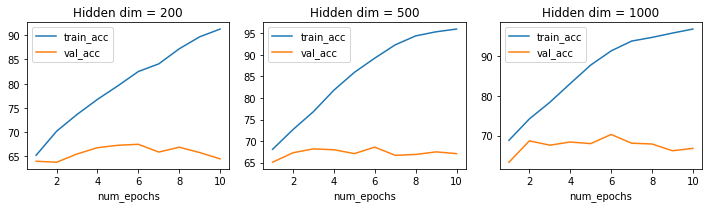

In [122]:
plt.figure(1, figsize=(10,3))
plt.subplot(131)
plt.plot(range(1,11), train_accs_array_hid[0], label='train_acc')
plt.plot(range(1,11), val_accs_array_hid[0], label='val_acc')
plt.title('Hidden dim = 200')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(132)
plt.plot(range(1,11), train_accs_array_hid[1], label='train_acc')
plt.plot(range(1,11), val_accs_array_hid[1], label='val_acc')
plt.title('Hidden dim = 500')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(133)
plt.plot(range(1,11), train_accs_array_hid[2], label='train_acc')
plt.plot(range(1,11), val_accs_array_hid[2], label='val_acc')
plt.title('Hidden dim = 1000')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.tight_layout()

In [123]:
np.amax(val_accs_array_hid, axis=1)

array([67.5, 68.6, 70.3])

### 2. Size of hidden dimension (RNN) 

In [150]:
num_epochs = 10
hidden_sizes = [200, 500] #[200, 500, 1000]
models_hid_rnn = []
train_accs_array_hid_rnn = np.empty([len(hidden_sizes), num_epochs])
val_accs_array_hid_rnn = np.empty([len(hidden_sizes), num_epochs])

for i in range(len(hidden_sizes)):
    model = RNN(weight, hidden_size=hidden_sizes[i], num_layers=1, num_classes=3)
    model, train_accs, val_accs = train()
    models_hid_rnn.append(model)
    train_accs_array_hid_rnn[i]=train_accs
    val_accs_array_hid_rnn[i]=val_accs

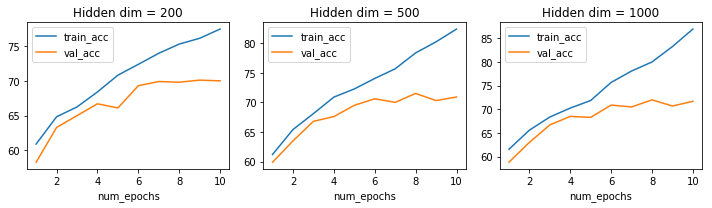

In [16]:
plt.figure(1, figsize=(10,3))
plt.subplot(131)
plt.plot(range(1,11), train_accs_array_hid_rnn[0], label='train_acc')
plt.plot(range(1,11), val_accs_array_hid_rnn[0], label='val_acc')
plt.title('Hidden dim = 200')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(132)
plt.plot(range(1,11), train_accs_array_hid_rnn[1], label='train_acc')
plt.plot(range(1,11), val_accs_array_hid_rnn[1], label='val_acc')
plt.title('Hidden dim = 500')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(133)
plt.plot(range(1,11), train_accs_array_hid_rnn[2], label='train_acc')
plt.plot(range(1,11), val_accs_array_hid_rnn[2], label='val_acc')
plt.title('Hidden dim = 1000')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
np.amax(val_accs_array_hid_rnn, axis=1)

array([70.1, 71.5, 72. ])

In [35]:
len(list(models_hid_rnn[2].parameters())[7])

3000

### 3. Kernel size for CNN

In [151]:
kernel_sizes = [5,7]
models_ker = []
train_accs_array_ker = np.empty([len(kernel_sizes), num_epochs])
val_accs_array_ker = np.empty([len(kernel_sizes), num_epochs])

for i in range(len(kernel_sizes)):
    model = CNN(weight, hidden_size=200, kernel_size=kernel_sizes[i], num_layers=2, num_classes=3)
    model, train_accs, val_accs = train()
    models_ker.append(model)
    train_accs_array_ker[i]=train_accs
    val_accs_array_ker[i]=val_accs

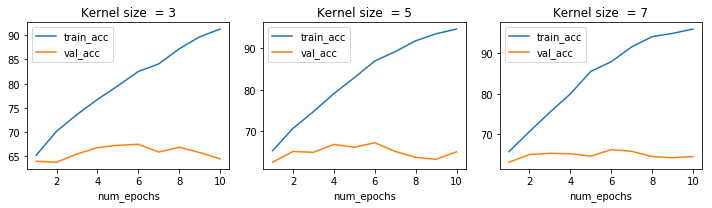

In [158]:
plt.figure(1, figsize=(10,3))
plt.subplot(131)
plt.plot(range(1,11), train_accs_array_hid[0], label='train_acc')
plt.plot(range(1,11), val_accs_array_hid[0], label='val_acc')
plt.title('Kernel size  = 3')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(132)
plt.plot(range(1,11), train_accs_array_ker[0], label='train_acc')
plt.plot(range(1,11), val_accs_array_ker[0], label='val_acc')
plt.title('Kernel size  = 5')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(133)
plt.plot(range(1,11), train_accs_array_ker[1], label='train_acc')
plt.plot(range(1,11), val_accs_array_ker[1], label='val_acc')
plt.title('Kernel size  = 7')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.tight_layout()

In [161]:
np.amax(val_accs_array_ker, axis=1)

array([67.2, 66.2])

## Get correct/incorrect predictions

In [141]:
def get_predictions(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    incorrect = 0
    correct_seqs = []
    incorrect_seqs = []
    
    model.eval()
    for data_1, data_2, lengths_1, lengths_2, labels in loader:
        data_1, data_2, lengths_1, lengths_2, labels = data_1.to(device), data_2.to(device), lengths_1.to(device), lengths_2.to(device), labels.to(device)
        data_batch_1, data_batch_2, lengths_batch_1, lengths_batch_2, label_batch = data_1, data_2, lengths_1, lengths_2, labels
        outputs = F.softmax(model(data_batch_1, data_batch_2, lengths_batch_1, lengths_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        for i in range(len(predicted.eq(labels.view_as(predicted)))):
            if correct > 2 and incorrect > 2: 
                break
            if predicted.eq(labels.view_as(predicted))[i] == 1:
                correct+=1
                correct_seqs.append([data_1[i], data_2[i], predicted[i], labels[i]])
            elif predicted.eq(labels.view_as(predicted))[i] == 0:
                incorrect+=1
                incorrect_seqs.append([data_1[i], data_2[i], predicted[i], labels[i]])

    return correct_seqs, incorrect_seqs

In [142]:
correct_seqs, incorrect_seqs = get_predictions(val_loader, best_cnn)

In [144]:
def detok(index_pair):
    seq1 = []
    seq2 = []
    for idx in index_pair[0]:
        token = id2token[idx]
        if token != '<pad>':
            seq1.append(token)
    for idx in index_pair[1]:
        token = id2token[idx]
        if token != '<pad>':
            seq2.append(token)
        
    return seq1, seq2

In [145]:
seq1, seq2= detok(incorrect_seqs[1])

In [146]:
seq1, seq2

(['Two', 'people', 'are', 'in', 'a', 'green', 'forest', '.'],
 ['The', 'forest', 'is', 'not', 'dead', '.'])

In [147]:
incorrect_seqs[1][2], incorrect_seqs[1][3]

(tensor([0], device='cuda:0'), tensor(1, device='cuda:0'))

## Test on MultiNLI

### Load data

In [22]:
with open('mnli_val.tsv') as f: 
    test_pairs = f.readlines()

In [24]:
test_data = []
test_target = []
test_genre = []

for line in test_pairs:
    seq1 = line.split('\t')[0].split()
    seq2 = line.split('\t')[1].split()
    label = line.split('\t')[2]
    genre = line.split('\t')[3].split()
    
    test_data.append([seq1, seq2])
    test_genre.append(genre)
    if label == 'contradiction':
        test_target.append(0)
    elif label == 'entailment':
        test_target.append(1)
    elif label == 'neutral':
        test_target.append(2)

test_data.pop(0)
test_genre.pop(0)
test_target = np.array(test_target)

In [25]:
unique_genre = np.unique(test_genre)

In [26]:
unique_genre

array(['fiction', 'government', 'slate', 'telephone', 'travel'],
      dtype='<U10')

In [27]:
test_data_fiction = []
test_data_government = []
test_data_slate = []
test_data_telephone = []
test_data_travel = []

test_target_fiction = []
test_target_government = []
test_target_slate = []
test_target_telephone = []
test_target_travel = []

for i in range(len(test_genre)):
    if test_genre[i] == ['fiction']:
        test_data_fiction.append(test_data[i])
        test_target_fiction.append(test_target[i])
    elif test_genre[i] == ['government']:
        test_data_government.append(test_data[i])
        test_target_government.append(test_target[i])
    elif test_genre[i] == ['slate']:
        test_data_slate.append(test_data[i])
        test_target_slate.append(test_target[i])
    elif test_genre[i] == ['telephone']:
        test_data_telephone.append(test_data[i])
        test_target_telephone.append(test_target[i])
    elif test_genre[i] == ['travel']:
        test_data_travel.append(test_data[i])
        test_target_travel.append(test_target[i])

In [40]:
test_data_indices_fiction = token2index_dataset(test_data_fiction)
test_data_indices_government = token2index_dataset(test_data_government)
test_data_indices_slate = token2index_dataset(test_data_slate)
test_data_indices_telephone = token2index_dataset(test_data_telephone)
test_data_indices_travel = token2index_dataset(test_data_travel)

In [41]:
test_dataset_fiction = snliDataset(test_data_indices_fiction, test_target_fiction)
test_loader_fiction = torch.utils.data.DataLoader(dataset=test_dataset_fiction, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

test_dataset_government = snliDataset(test_data_indices_government, test_target_government)
test_loader_government = torch.utils.data.DataLoader(dataset=test_dataset_government, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

test_dataset_slate = snliDataset(test_data_indices_slate, test_target_slate)
test_loader_slate = torch.utils.data.DataLoader(dataset=test_dataset_slate, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

test_dataset_telephone = snliDataset(test_data_indices_telephone, test_target_telephone)
test_loader_telephone = torch.utils.data.DataLoader(dataset=test_dataset_telephone, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

test_dataset_travel = snliDataset(test_data_indices_travel, test_target_travel)
test_loader_travel = torch.utils.data.DataLoader(dataset=test_dataset_travel, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [51]:
test_acc_fiction_cnn = test_model(test_loader_fiction, models_hid[0])
test_acc_government_cnn = test_model(test_loader_government, models_hid[0])
test_acc_slate_cnn = test_model(test_loader_slate, models_hid[0])
test_acc_telephone_cnn = test_model(test_loader_telephone, models_hid[0])
test_acc_travel_cnn = test_model(test_loader_travel, models_hid[0])

test_acc_fiction_rnn = test_model(test_loader_fiction, models_hid_rnn[0])
test_acc_government_rnn = test_model(test_loader_government, models_hid_rnn[0])
test_acc_slate_rnn = test_model(test_loader_slate, models_hid_rnn[0])
test_acc_telephone_rnn = test_model(test_loader_telephone, models_hid_rnn[0])
test_acc_travel_rnn = test_model(test_loader_travel, models_hid_rnn[0])

In [52]:
print('test_acc from cnn model in fiction: ', test_acc_fiction_cnn)
print('test_acc from cnn model in government: ', test_acc_government_cnn)
print('test_acc from cnn model in slate: ', test_acc_slate_cnn)
print('test_acc from cnn model in telephone: ', test_acc_telephone_cnn)
print('test_acc from cnn model in travel: ', test_acc_travel_cnn)

print('test_acc from rnn model in fiction: ', test_acc_fiction_rnn)
print('test_acc from rnn model in government: ', test_acc_government_rnn)
print('test_acc from rnn model in slate: ', test_acc_slate_rnn)
print('test_acc from rnn model in telephone: ', test_acc_telephone_rnn)
print('test_acc from rnn model in travel: ', test_acc_travel_rnn)

test_acc from cnn model in fiction:  44.824120603015075
test_acc from cnn model in government:  43.110236220472444
test_acc from cnn model in slate:  43.612774451097806
test_acc from cnn model in telephone:  43.98009950248756
test_acc from cnn model in travel:  45.11201629327902
test_acc from rnn model in fiction:  50.35175879396985
test_acc from rnn model in government:  47.539370078740156
test_acc from rnn model in slate:  45.50898203592814
test_acc from rnn model in telephone:  49.75124378109453
test_acc from rnn model in travel:  49.59266802443992


In [68]:
pytorch_total_params = sum(p.numel() for p in  models_hid_rnn[1].parameters() if p.requires_grad)

In [69]:
pytorch_total_params

2908003